# Texture Enhancement for Endoscopy Image

참고 논문 
- TXI: Texture and Color Enhancement Imaging for Endoscopic Image Enhancement, Tomoya Sato, 2021
[https://onlinelibrary.wiley.com/doi/epdf/10.1155/2021/5518948]

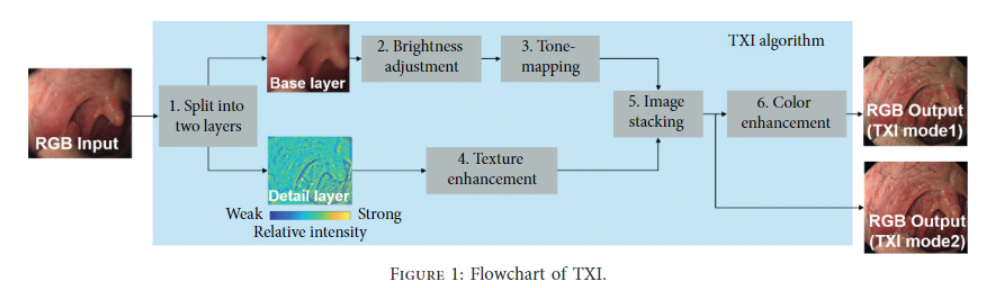

## 1. Split into two layers

In [6]:
from PIL import Image 
import os 
import cv2 
from matplotlib import pyplot as plt 
import numpy as np

def get_ksize(sigma):
    return int(((sigma - 0.8)/0.15) + 2.0)

def get_base_layer(image, ksize = 0, sigma=5):
    if ksize == 0:
        ksize = get_ksize(sigma)
    sep_k = cv2.getGaussianKernel(ksize, sigma)
    return cv2.filter2D(image, -1, np.outer(sep_k, sep_k))

def ssr(image, sigma):
    return np.log10(image) - np.log10(get_base_layer(image, ksize=0, sigma=sigma))

def split(image_array,sigma = 10):
    base_layer = get_base_layer(image = image_array, sigma = sigma)
    detail_layer = np.zeros(image_array.shape)
    for i in range(3):
        for x in range(image_array.shape[0]):
            for y in range(image_array.shape[1]):
                value = image_array[x][y][i] / base_layer[x][y][i]
                if value > 255:
                    detail_layer[x][y][i] = 255
                else :
                    detail_layer[x][y][i] = value
    return base_layer, detail_layer

## 2. Brightness Adjustment

In [7]:

def brightness_adj(image_array, base_layer):
    h = 0.25 * image_array.max()
    ALPHA = 1.0/1.4
    b_max_layer = np.ndarray((image_array.shape[0], image_array.shape[1]))
    b_prime_max_layer = np.ndarray((image_array.shape[0], image_array.shape[1]))
    for x in range(image_array.shape[0]):
        for y in range(image_array.shape[1]):
            b_max_layer[x][y] = image_array[x][y].max() 

    for x in range(image_array.shape[0]):
        for y in range(image_array.shape[1]):
            if b_max_layer[x][y] < h:
                b_prime_max_layer[x][y] = (h / (h**ALPHA)) * (b_max_layer[x][y]**ALPHA)
            else:
                b_prime_max_layer[x][y] = b_max_layer[x][y]

    m_layer = np.ndarray((image_array.shape[0], image_array.shape[1]))
    for x in range(image_array.shape[0]):
        for y in range(image_array.shape[1]):
            if b_prime_max_layer[x][y] == 0 or b_max_layer[x][y] == 0:
                m_layer[x][y] = 0
            else:
                m_layer[x][y] = b_prime_max_layer[x][y] / b_max_layer[x][y]

    b_prime_layer = base_layer.copy() 
    for x in range(base_layer.shape[0]):
        for y in range(base_layer.shape[1]):
            b_prime_layer[x][y] = base_layer[x][y] * m_layer[x][y]
    return b_prime_layer

## 3. Tone Mapping

In [8]:
def gamma_correction(arr, gamma = 1.5):
    image = arr.astype(np.float32)
    result = ((image / 255) ** ( 1 / gamma) * 255)
    result = result.astype(np.uint8)
    return result 

def tone_mapping(b_prime_layer, gamma = 1.5):
    b_double_prime_layer = gamma_correction(arr = b_prime_layer, gamma = gamma)
    return b_double_prime_layer

## 4. Texture Enhancement

In [9]:
def texture_enhancement(arr, g = 1.2):
    result = np.zeros(arr.shape)
    for x in range(arr.shape[0]):
        for y in range(arr.shape[1]):
            result[x][y] = arr[x][y] ** g 
    return result 

## 5. Image Stacking

In [10]:
def image_stack(image_array, b_double_prime_layer, d_prime_layer):
    o2_layer = np.zeros(image_array.shape)
    for i in range(3):
        for x in range(o2_layer.shape[0]):
            for y in range(o2_layer.shape[1]):
                value = b_double_prime_layer[x][y][i] * d_prime_layer[x][y][i]
                if value > 255:
                    o2_layer[x][y][i] = 255
                else:
                    o2_layer[x][y][i] = value
    return o2_layer

## Test

test image(from the paper)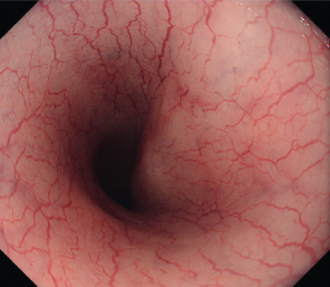

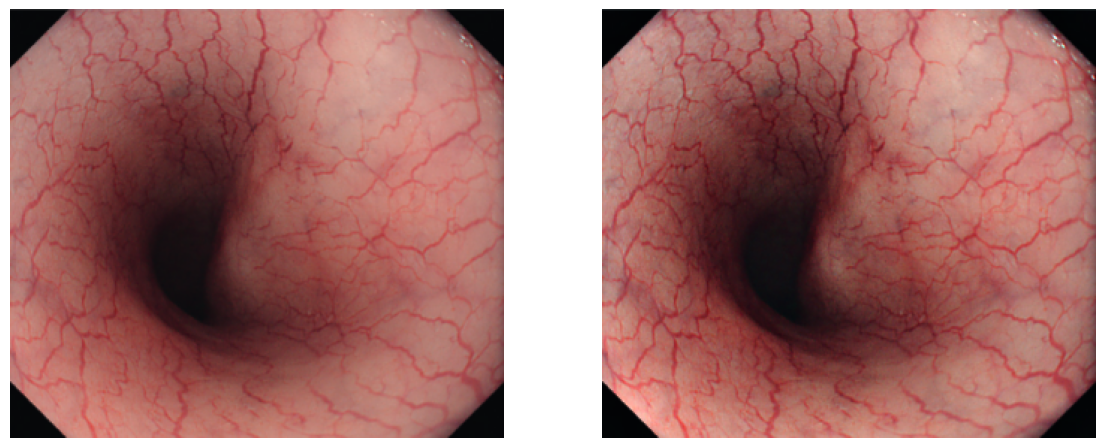

In [26]:
import os 

def all_process(image_array, sigma = 20, gamma = 1.0, g = 1.5):
    base_layer, detail_layer = split(image_array, sigma)
    b_prime_layer = brightness_adj(image_array, base_layer)
    b_double_prime_layer = tone_mapping(b_prime_layer, gamma)
    d_prime_layer = texture_enhancement(arr = detail_layer, g = g)
    o2_layer = image_stack(image_array, b_double_prime_layer, d_prime_layer)
    o2_img = Image.fromarray(o2_layer.astype(np.uint8))
    return o2_img



original_image = Image.open('./test_image.png').convert("RGB")
image = original_image.copy()
image_array = np.asarray(image)
o2_image = all_process(image_array)

## visualization
plt.figure(figsize=(14, 7))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(original_image)
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(o2_image)
plt.show()

